### Universidad Tecnológica de Panamá
#### Maestría de Analítica de Datos
#### Proyecto Final de Modelos Predictivos
#### Predicción del Puntaje Crediticio a partir de Características Demográficas y Financieras de Clientes de Tarjetas de Crédito
##### Nombre: Caroline Cárdenas

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from lazypredict.Supervised import LazyRegressor
from xgboost import XGBRegressor

In [2]:
# Cargar datos y crear variables derivadas
df = pd.read_csv('users_data_credit_cards.csv')
df = df.drop(columns=['id', 'address', 'latitude', 'longitude'])
df['gender'] = df['gender'].astype(int)
df['debt_to_income_ratio'] = df['total_debt'] / df['yearly_income']
df['years_to_retirement'] = df['retirement_age'] - df['current_age']


In [3]:
print("\nPrimeras filas del dataset:")
print(df.head())


Primeras filas del dataset:
   current_age  retirement_age  birth_year  birth_month  gender  \
0           53              66        1966           11       0   
1           53              68        1966           12       0   
2           81              67        1938           11       0   
3           63              63        1957            1       0   
4           43              70        1976            9       1   

   per_capita_income  yearly_income  total_debt  credit_score  \
0           29278.00       59696.00   127613.00        787.00   
1           37891.00       77254.00   191349.00        701.00   
2           22681.00       33483.00      196.00        698.00   
3          163145.00      249925.00   202328.00        722.00   
4           53797.00      109687.00   183855.00        675.00   

   num_credit_cards  debt_to_income_ratio  years_to_retirement  
0                 5                  2.14                   13  
1                 5                  2.48      

In [4]:
print("\nInformación general del dataset:")
df.info()


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   current_age           12000 non-null  int64  
 1   retirement_age        12000 non-null  int64  
 2   birth_year            12000 non-null  int64  
 3   birth_month           12000 non-null  int64  
 4   gender                12000 non-null  int64  
 5   per_capita_income     12000 non-null  float64
 6   yearly_income         12000 non-null  float64
 7   total_debt            12000 non-null  float64
 8   credit_score          12000 non-null  float64
 9   num_credit_cards      12000 non-null  int64  
 10  debt_to_income_ratio  12000 non-null  float64
 11  years_to_retirement   12000 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 1.1 MB


In [5]:
print("\nEstadísticas descriptivas:")
print(df.describe(include='all'))


Estadísticas descriptivas:
       current_age  retirement_age  birth_year  birth_month   gender  \
count     12000.00        12000.00    12000.00     12000.00 12000.00   
mean         44.08           64.86     1976.57         6.49     0.49   
std          15.66            3.10       16.32         3.48     0.50   
min          18.00           50.00     1918.00         1.00     0.00   
25%          31.00           62.00     1963.00         3.00     0.00   
50%          44.00           65.00     1977.00         7.00     0.00   
75%          57.00           67.00     1990.00        10.00     1.00   
max         101.00           79.00     2004.00        12.00     1.00   

       per_capita_income  yearly_income  total_debt  credit_score  \
count           12000.00       12000.00    12000.00      12000.00   
mean            20579.20       46302.88    65664.81        565.22   
std              7262.76       22063.87    46291.22        141.97   
min                 0.00           1.00        

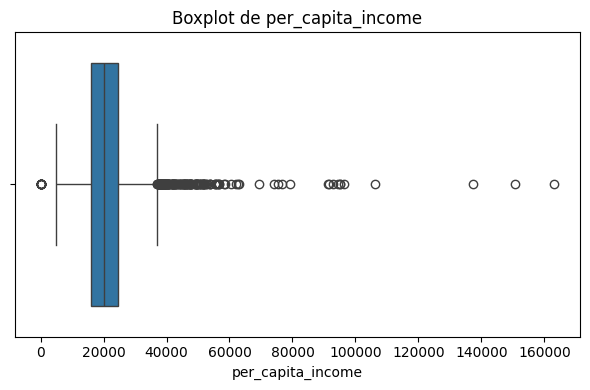

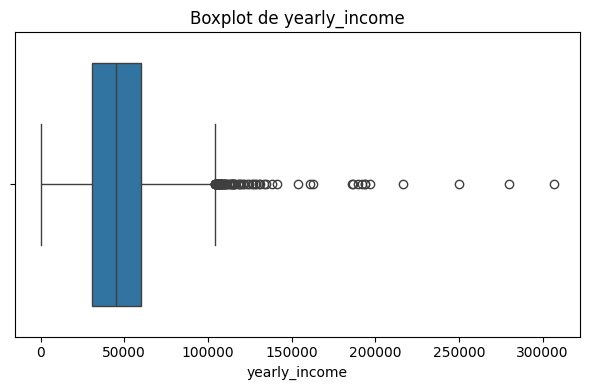

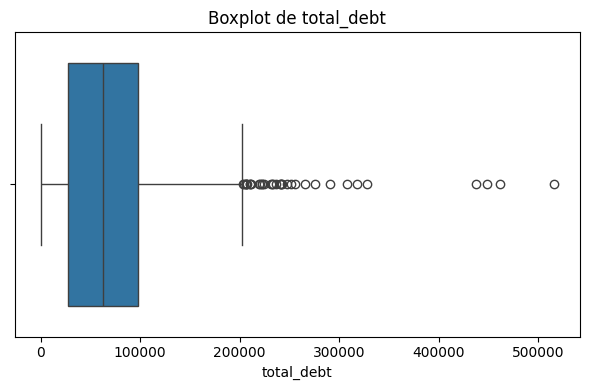

In [6]:
# Identificación de outliers con gráficas de caja
monetary_cols = ['per_capita_income', 'yearly_income', 'total_debt']

for col in monetary_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()

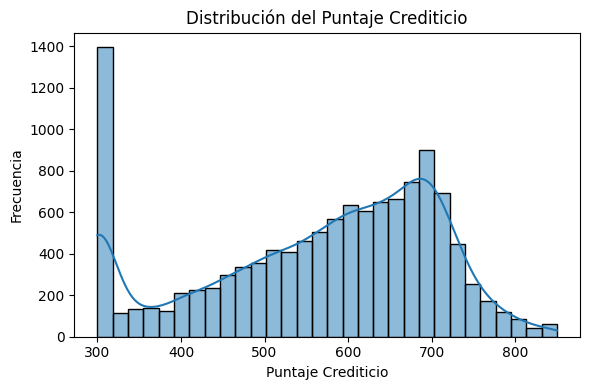

In [7]:
# EDA: Histograma del credit score
plt.figure(figsize=(6, 4))
sns.histplot(df['credit_score'], bins=30, kde=True)
plt.title('Distribución del Puntaje Crediticio')
plt.xlabel('Puntaje Crediticio')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

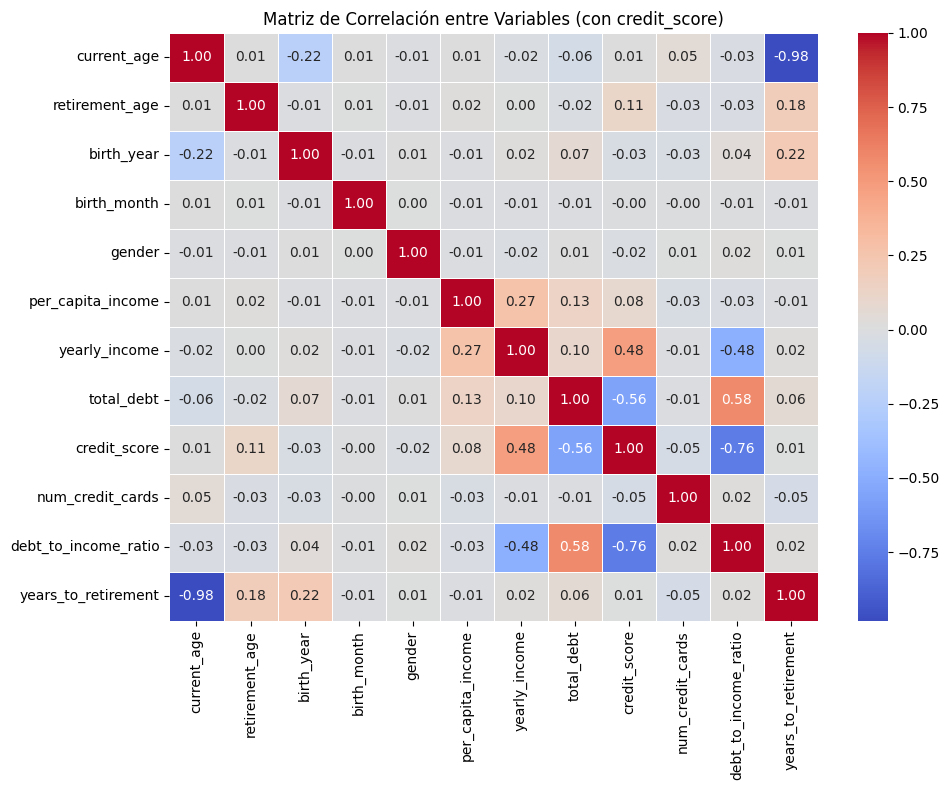

In [8]:
# Matriz de correlación incluyendo credit_score
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Variables (con credit_score)')
plt.tight_layout()
plt.show()

In [9]:
# Preparar datos para el modelo
feature_cols = [
    'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
    'num_credit_cards', 'debt_to_income_ratio', 'years_to_retirement']

X = df[feature_cols]
y = df['credit_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Crear LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)

pd.set_option('display.max_rows', None)
display(models)

100%|██████████| 42/42 [03:29<00:00,  5.00s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 8
[LightGBM] [Info] Start training from score 565.024310


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.86,0.86,52.17,0.23
LGBMRegressor,0.86,0.86,52.85,0.06
HistGradientBoostingRegressor,0.86,0.86,53.19,0.21
ExtraTreesRegressor,0.84,0.84,56.15,1.88
RandomForestRegressor,0.84,0.84,56.31,3.30
BaggingRegressor,0.82,0.82,60.12,0.36
GradientBoostingRegressor,0.81,0.81,60.64,0.73
MLPRegressor,0.79,0.79,63.78,2.59
KNeighborsRegressor,0.75,0.75,70.54,0.06


In [11]:
# Modelo: XGBRegressor
model_xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
model_xgb.fit(X_train_scaled, y_train)

y_pred_xgb = model_xgb.predict(X_test_scaled)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("📊 Resultados - XGBRegressor")
print(f'R² test: {r2_xgb:.4f}')
print(f"MAPE: {mape_xgb:.4f} ({mape_xgb * 100:.2f}%)")
print(f'MAE: {mae_xgb:.2f}')
print(f'RMSE: {rmse_xgb:.2f}')

📊 Resultados - XGBRegressor
R² test: 0.8621
MAPE: 0.0638 (6.38%)
MAE: 35.45
RMSE: 52.17


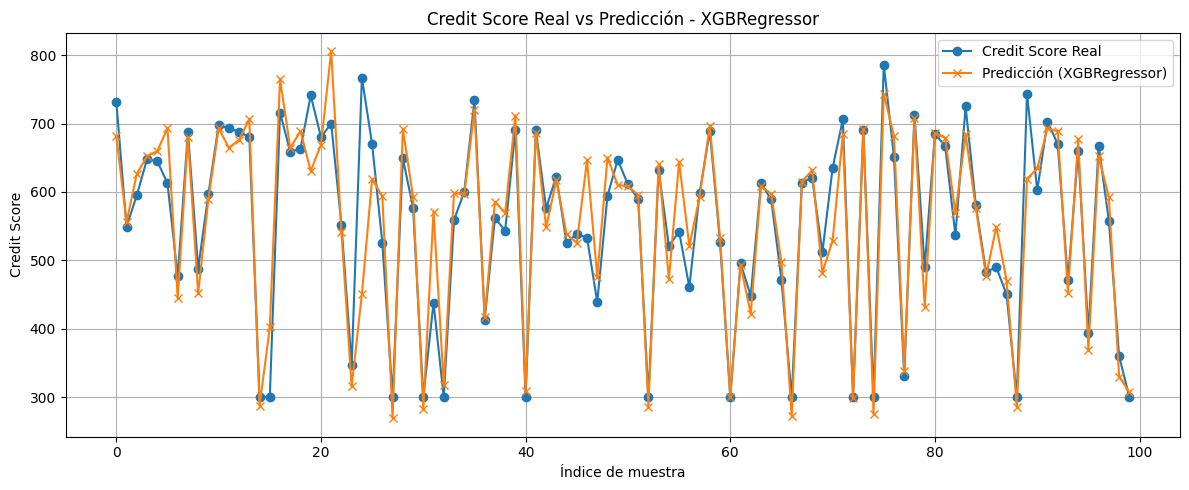

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Credit Score Real', marker='o')
plt.plot(y_pred_xgb[:100], label='Predicción (XGBRegressor)', marker='x')
plt.title('Credit Score Real vs Predicción - XGBRegressor')
plt.xlabel('Índice de muestra')
plt.ylabel('Credit Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Modelo: HistGradientBoosting
model_hgb = HistGradientBoostingRegressor(random_state=42)
model_hgb.fit(X_train_scaled, y_train)

y_pred_hgb = model_hgb.predict(X_test_scaled)
r2_hgb = r2_score(y_test, y_pred_hgb)
mae_hgb = mean_absolute_error(y_test, y_pred_hgb)
rmse_hgb = np.sqrt(mean_squared_error(y_test, y_pred_hgb))
mape_hgb = mean_absolute_percentage_error(y_test, y_pred_hgb)

print("\n📊 Resultados - HistGradientBoostingRegressor")
print(f'R² test: {r2_hgb:.4f}')
print(f"MAPE: {mape_hgb:.4f} ({mape_hgb * 100:.2f}%)")
print(f'MAE: {mae_hgb:.2f}')
print(f'RMSE: {rmse_hgb:.2f}')


📊 Resultados - HistGradientBoostingRegressor
R² test: 0.8566
MAPE: 0.0599 (5.99%)
MAE: 34.26
RMSE: 53.19


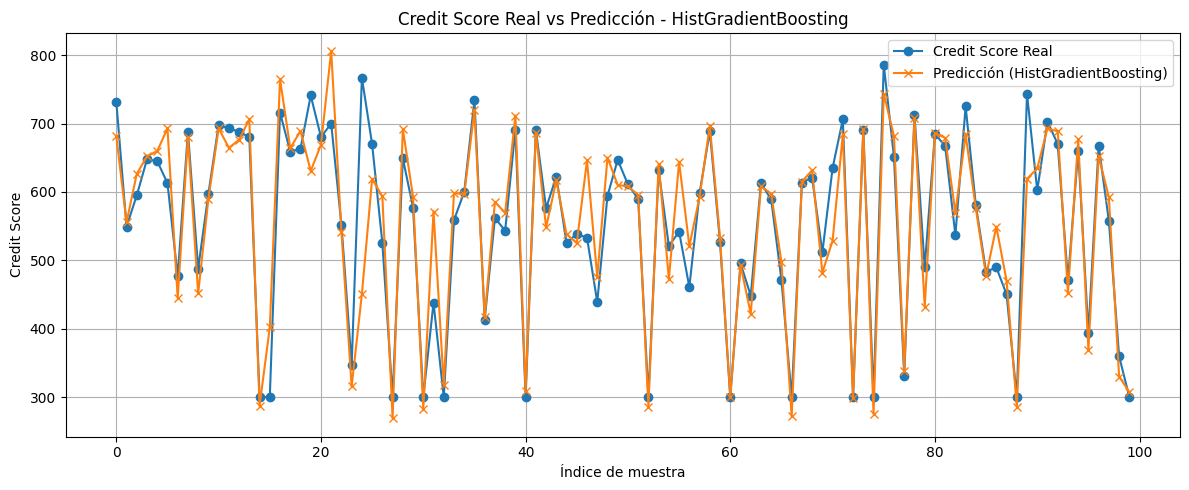

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Credit Score Real', marker='o')
plt.plot(y_pred_xgb[:100], label='Predicción (HistGradientBoosting)', marker='x')
plt.title('Credit Score Real vs Predicción - HistGradientBoosting')
plt.xlabel('Índice de muestra')
plt.ylabel('Credit Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Entrenar y evaluar Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_scaled, y_train)


y_pred_rf = model_rf.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f'R² test: {r2:.4f}')
print(f"MAPE: {mape_rf:.4f} ({mape_rf * 100:.2f}%)")
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


R² test: 0.8393
MAPE: 0.0614 (6.14%)
MAE: 35.44
RMSE: 56.31


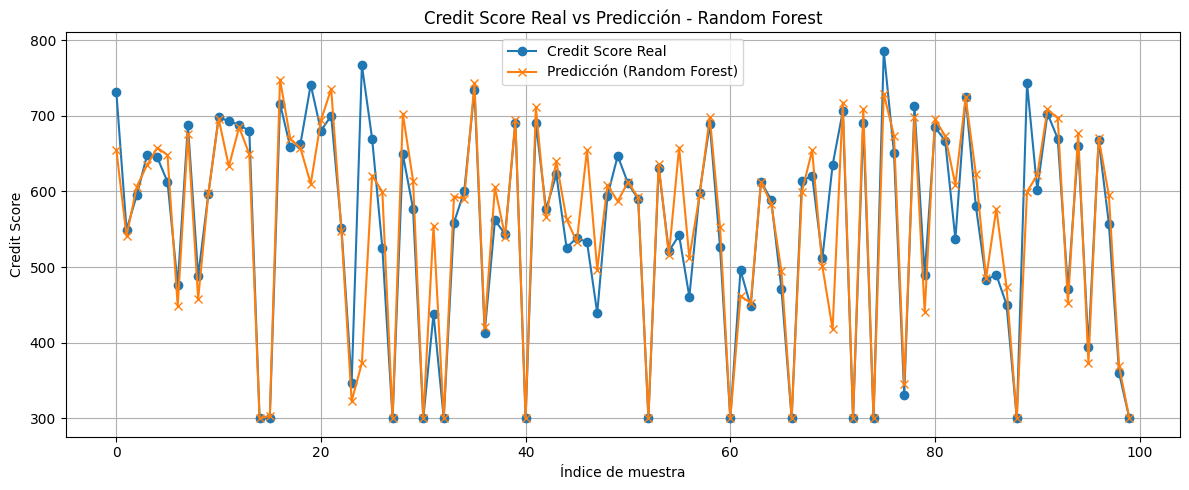

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Credit Score Real', marker='o')
plt.plot(y_pred_rf[:100], label='Predicción (Random Forest)', marker='x')
plt.title('Credit Score Real vs Predicción - Random Forest')
plt.xlabel('Índice de muestra')
plt.ylabel('Credit Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:

# Función de asignación de límite según el credit score y otros factores
def asignar_limite(row, pred_score):
    if np.isnan(pred_score):
        ingreso = row['yearly_income']
        deuda = row['total_debt']
        per_capita = row['per_capita_income']
        edad = row['current_age']
        tarjetas = row['num_credit_cards']
        ratio = row['debt_to_income_ratio']

        if tarjetas > 3 and ratio > 0.4:
            return 'Evaluación manual'
        elif 25 <= edad <= 55 and ingreso > 60000 and deuda < 10000 and tarjetas >= 3:
            return 5000
        elif 18 <= edad <= 65 and 30000 <= ingreso <= 60000 and deuda < 15000 and 1 <= tarjetas <= 2:
            return 3000
        elif edad < 25 or edad > 65 or ingreso < 30000 or deuda > 20000:
            return 1500
        else:
            return 1000  # sin historial, conservador
    else:
        if 800 <= pred_score <= 850:
            return 12000
        elif 740 <= pred_score < 800:
            return 8000
        elif 670 <= pred_score < 740:
            return 5000
        elif 580 <= pred_score < 670:
            return 2500
        else:
            return 1000


In [18]:
# Predecir credit_score y asignar límite
df['predicted_score'] = model_rf.predict(scaler.transform(df[feature_cols]))
df['limite_tarjeta'] = df.apply(lambda row: asignar_limite(row, row['predicted_score']), axis=1)

In [19]:
# Mostrar algunos resultados
df[['current_age', 'retirement_age', 'years_to_retirement', 'num_credit_cards',
    'credit_score', 'predicted_score','debt_to_income_ratio','limite_tarjeta']].head(10)

,current_age,retirement_age,years_to_retirement,num_credit_cards,credit_score,predicted_score,debt_to_income_ratio,limite_tarjeta
0,53,66,13,5,787.00,580.70,2.14,2500
1,53,68,15,5,701.00,641.61,2.48,2500
2,81,67,-14,5,698.00,707.28,0.01,5000
3,63,63,0,4,722.00,662.55,0.81,2500
4,43,70,27,1,675.00,682.41,1.68,5000
5,42,70,28,3,704.00,723.67,0.00,5000
6,36,67,31,3,672.00,663.91,1.99,2500
7,26,67,41,1,728.00,696.40,2.10,5000
8,81,66,-15,5,755.00,680.92,0.07,5000
9,34,60,26,1,810.00,710.90,2.13,5000


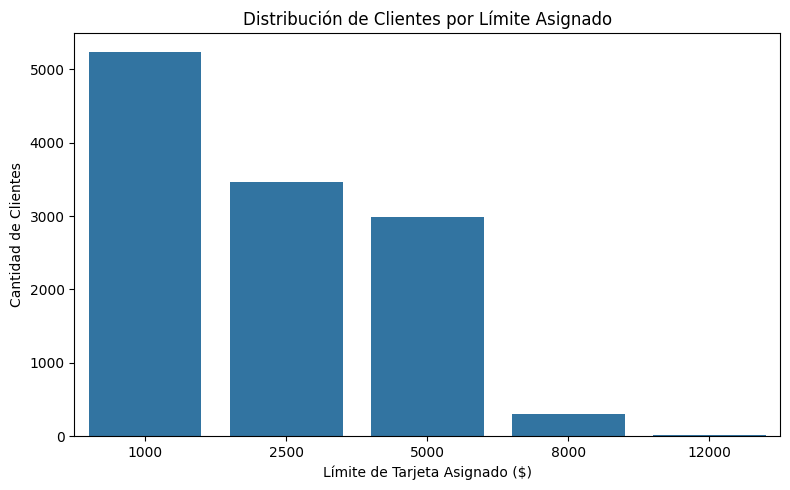

In [20]:
# Visualizar la distribución de clientes por límite asignado
limite_summary = df['limite_tarjeta'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=limite_summary.index.astype(str), y=limite_summary.values)
plt.title('Distribución de Clientes por Límite Asignado')
plt.xlabel('Límite de Tarjeta Asignado ($)')
plt.ylabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()